In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from textwrap import wrap
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from alvra_tools.timing_tool import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')

<a id='Load'></a>
## Load data

In [2]:
pgroup = 'p21210'
Loaddir_name = 'Reduced_XANES_timescans_test'

#runlist=np.arange(58, 60, 1)
runlist = [266, 267]
#runlist = [116, 117]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

try:
    del Delays_corr_scan
except:
    pass

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
try:
    print ('{} scan(s), {} steps each, {} shots'.format(len(runlist), int(len(DataDiode1_pump)/len(runlist)), len(Delays_corr_scan)))
except:
    print ('No TT data, {} scan(s), {} steps each'.format(len(runlist), int(len(DataDiode1_pump)/len(runlist))))

[266, 267]
2 scan(s), 61 steps each, 20941 shots


# Average scans:
### [with TT (one or two diodes)](#TT)
### without TT:
* [One diode](#Ave_data_noTT)
* [Overlay different scans one diode](#Overlay_1diode)

* [Two diodes](#Ave_data_noTT_2)
* [Overlay different scans two diodes](#Overlay_2diodes)
* [Average the 2 diodes](#average_2diodes)

# [Reload data](#Load)

<a id='Ave_data_noTT'></a>
## Average scans w/o TT (same delay axis) 1 diode

Scan is done with the stage in fs


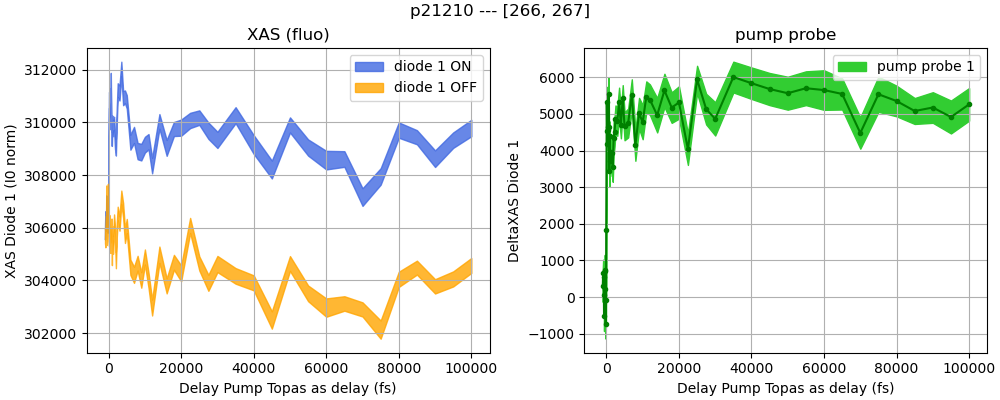

In [3]:
Delay_fs, DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1 = \
Plot_AveScans_1diode(titlestring_stack, scan, data, len(runlist), timescan=True)

## save the averaged spectra to load them overlaid

In [4]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_1diode(reducedir, run_name, scan, 
                         average_array(DataDiode1_pump, 0), 
                         average_array(DataDiode1_unpump, 0), 
                         average_array(Pump_probe_Diode1, 0), 
                         average_array(goodshots1, 0),
                         average_array(correlation1, 0))
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0266-Timescan_long2_CuNi_Ni_600nm_8344p5eV_001


<a id='Overlay_1diode'></a>
## Overlay different scans 1 diode

In [97]:
pgroup = 'p21210'
#runlist = np.arange(166, 171, 1)
runlist = [266]
Loaddir_folder = 'Reduced_timescans/averaged'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 1 runs: [266] from /sf/alvra/data/p21210/work/Claudio/Reduced_timescans/averaged/


['/sf/alvra/data/p21210/work/Claudio/Reduced_timescans/averaged/run0266-Timescan_long2_CuNi_Ni_600nm_8344p5eV_001/run_array.npy']

Scan is done with the stage in fs


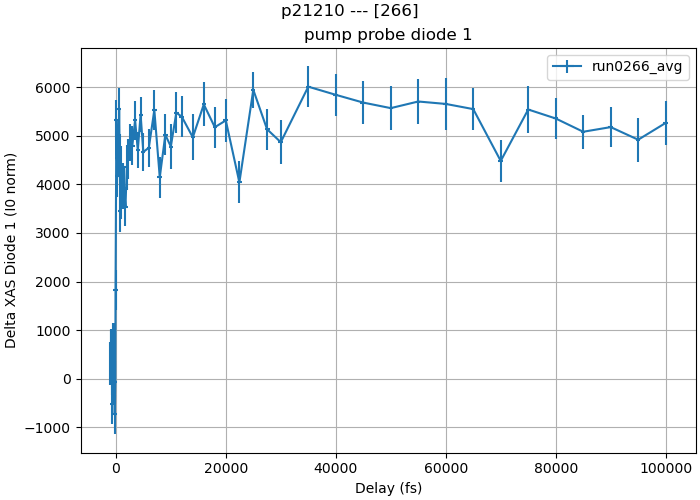

In [98]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

keys = []
#lab = ['DMM','N2Q','N4PY']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        rbk = run_array[key]["readbacks"]
        t0mm = run_array[key]["timezero_mm"]
        params = run_array[key]["scan_params"]
        Delay_mm, Delay_fs = adjust_delayaxis(params, rbk, t0mm)
        
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.plot(Delay_fs, XAS1_pump_probe[:,0], label=runnumber)
        ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
#ax1.set_xlim(-1000, 50000)
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2466.35,2466.75, 2469.55, 2472], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe diode 1')
plt.show()

# [Reload data](#Load)

<a id='TT'></a>
## with TT

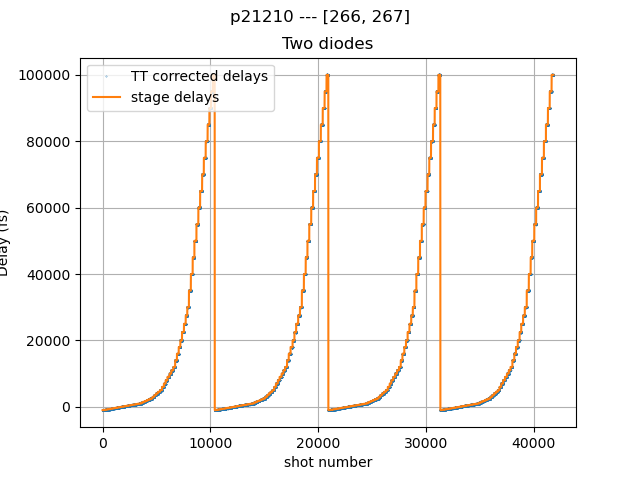

In [86]:
Two_diodes = True

##################################################

title=""
if Two_diodes:
    Pump_probe_scan  = Pump_probe_scan + Pump_probe_scan2
    Delays_corr_scan = Delays_corr_scan + Delays_corr_scan2
    Delays_fs_scan   = Delays_fs_scan + Delays_fs_scan2
    title = "Two diodes"
    
plt.figure()
plt.suptitle(titlestring_stack)
plt.title(title)
plt.plot(Delays_corr_scan, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_fs_scan, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

### variable binsize

In [87]:
numbins = 100
withTT = True

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_scan), np.shape(Delays_fs_scan))

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin),
                     np.arange(npt),
                     np.sort(x))

if not withTT:
    binList = histedges_equalN(Delays_fs_scan, numbins)
    pp_TT, binEdges, binNumber = binned_statistic(Delays_fs_scan, Pump_probe_scan, statistic='mean', bins=binList)
    pp_std, _, _ = binned_statistic(Delays_fs_scan, Pump_probe_scan, statistic='std', bins=binList)
else:
    binList = histedges_equalN(Delays_corr_scan, numbins)
    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='mean', bins=binList)
    pp_std, _, _ = binned_statistic(Delays_fs_scan, Pump_probe_scan, statistic='std', bins=binList)

bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.copy(bin_centres)
#Delay_fs_TT = np.copy(binList)
count = []
for index in range(len(bin_centres)):
    count.append(np.count_nonzero(binNumber == (index+1)))
err_pp = pp_std/np.sqrt(np.array(count))

(41825,) (41825,) (41825,)


### fix binsize with a range

In [84]:
binsize = 5 # in fs
withTT = True

min_delay = -250
max_delay = 1000

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_scan), np.shape(Delays_fs_scan))

binList = np.arange(min_delay, max_delay, binsize)

if not withTT:
    pp_TT, binEdges, binNumber = binned_statistic(Delays_fs_scan, Pump_probe_scan, statistic='mean', bins=binList)
    pp_std, _, _ = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='std', bins=binList)
else:
    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='mean', bins=binList)
    pp_std, _, _ = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='std', bins=binList)

bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
count = []
for index in range(len(bin_centres)):
    count.append(np.count_nonzero(binNumber == index+1))
err_pp = pp_std/np.sqrt(np.array(count))

(20941,) (20941,) (20941,)


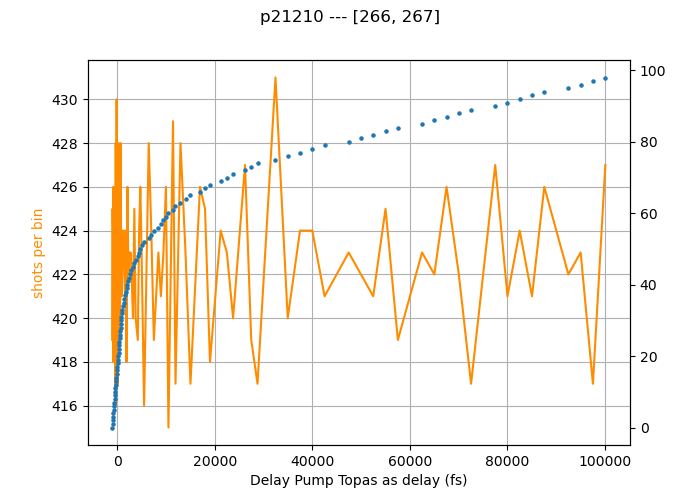

In [88]:
fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring_stack)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

delayrange = np.arange(0, len(Delay_fs_TT), 1)
ax1.plot(Delay_fs_TT, np.array(count), color = 'darkorange')
ax2.scatter(Delay_fs_TT, delayrange, s = 5)

ax1.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
ax1.set_ylabel('shots per bin', color='darkorange')
ax1.grid()
plt.show()

In [89]:
from scipy.special import erf
from scipy.optimize import curve_fit

def model_decay_1exp(t, t0, sig, amp1, tau1, C):
    first_exp  = 0.5*(np.exp(-1/tau1*(t-t0-sig**2/tau1))*(1 + erf((t-t0-sig**2/tau1)/(np.sqrt(2)*sig))))
    total = C + amp1*first_exp# + amp2*second_exp 
    return total

def model_decay_2exp(x, x0, sigma, amp1, tau1, C, amp2, tau2):
    first_exp  = 0.5*(np.exp(-1/tau1*(x-x0-sigma**2/tau1))*(1 + erf((x-x0-sigma**2/tau1)/(np.sqrt(2)*sigma))))
    second_exp = 0.5*(np.exp(-1/tau2*(x-x0-sigma**2/tau2))*(1 + erf((x-x0-sigma**2/tau2)/(np.sqrt(2)*sigma))))
    total = C + amp1*first_exp + amp2*second_exp 
    return total

risetime = 194.0318 fs
tau1 = 652793.6513 fs
tau2 = 2423722.2712 fs


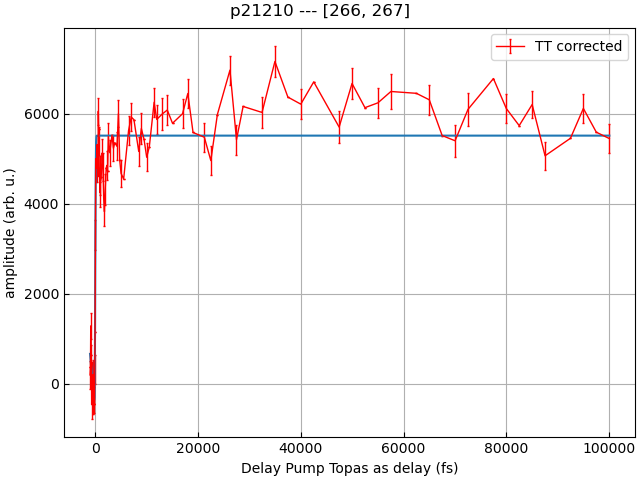

In [90]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(titlestring_stack)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.tick_params(direction='in')

#plt.plot(Delays_corr_scan, Pump_probe_scan, 'o', color='lightblue', markersize=0.5)
#plt.scatter(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corrected')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    
    # p0 = [0,  100,   10000,    1000, 1]
    # popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    # y_fit = model_decay_1exp(Delay_fs_TT, *popt)
    # print("risetime = {:.4f} fs".format(abs(popt[1])))
    # print("tau = {:.4f} fs".format(abs(popt[3])))
    
    p0 = [0,  100,   10000,    100, 0, 5000, 1000]
    popt,_  = curve_fit(model_decay_2exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    y_fit = model_decay_2exp(Delay_fs_TT, *popt)
    print("risetime = {:.4f} fs".format(abs(popt[1])*2.355))
    print("tau1 = {:.4f} fs".format(abs(popt[3])))
    print("tau2 = {:.4f} fs".format(abs(popt[6])))
    plt.plot(Delay_fs_TT, y_fit)
    
    # fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # #fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    # fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    # #fit.p0 = better_p0(fit.p0, 4,100)
    # fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
    # fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    # pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    # t0_mm = fit.popt[0]
    # width_fs = fit.popt[2]
    # plt.plot(Delay_fs_TT, pp_fit, color='green')
    # print("Width = {:.4f} fs".format(abs(width_fs)))

plt.xlabel("{} ({})".format(label, units))
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-4000, 2000)
#plt.xlim(-800, 2200)
plt.grid()
#plt.axvline(0)

plt.show()

## save the averaged spectra to load them overlaid

In [91]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

run_array = {}
run_array[run_name.split('-')[0]] = {"name": run_name,
                                    "Pump_probe_Diode1": pp_TT, 
                                    "errbars_pp": err_pp,
                                    "Delay_fs": Delay_fs_TT
                                    }
np.save(reducedir+run_name+'/run_array', run_array)

## Overlay TT corrected scans

In [92]:
pgroup = 'p21210'
#runlist = np.arange(166, 171, 1)
runlist = [266]
Loaddir_folder = 'Reduced_timescans/averaged'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 1 runs: [266] from /sf/alvra/data/p21210/work/Claudio/Reduced_timescans/averaged/


['/sf/alvra/data/p21210/work/Claudio/Reduced_timescans/averaged/run0266-Timescan_long2_CuNi_Ni_600nm_8344p5eV_001/run_array.npy']

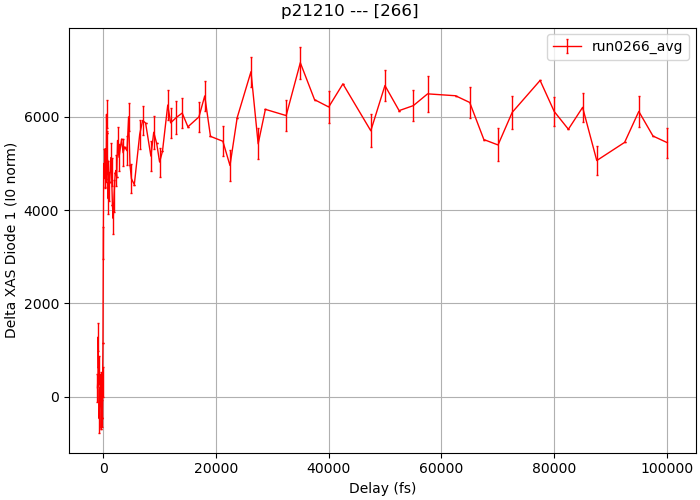

In [93]:
fig, ax1 = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

keys = []
#lab = ['DMM','N2Q','N4PY']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        pp_TT = run_array[key]["Pump_probe_Diode1"]
        err_pp = run_array[key]["errbars_pp"]
        Delay_fs_TT = run_array[key]["Delay_fs"]
 
        plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label=runnumber)
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
#ax1.set_xlim(-1000, 50000)
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2466.35,2466.75, 2469.55, 2472], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)
plt.show()

# [Reload data](#Load)

<a id='Ave_data_noTT_2'></a>
## Average scans (same X axis) 2 diodes

Scan is done with the stage in fs


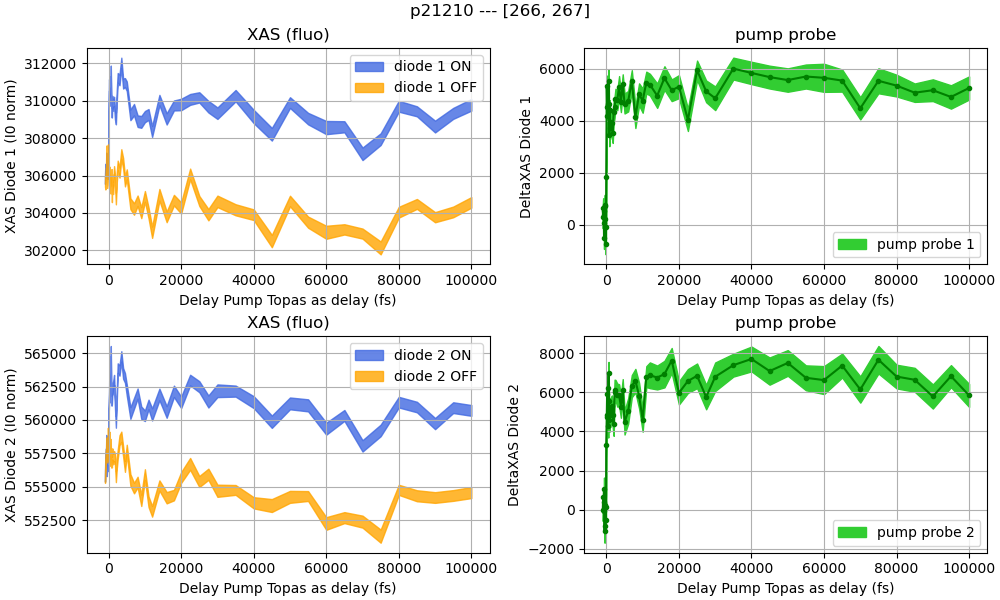

In [5]:
Delay_fs, DataDiode1_pump, DataDiode2_pump, DataDiode1_unpump, DataDiode2_unpump, Pump_probe_Diode1, Pump_probe_Diode2, goodshots1, goodshots2 = \
Plot_AveScans_2diodes(titlestring_stack, scan, data, len(runlist), timescan=True)

## save the averaged spectra to load them overlaid

In [7]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

def average_array(array, axis):
    return np.mean(array, axis=axis)
save_reduced_data_2diodes(reducedir, run_name, scan, 
                          average_array(DataDiode1_pump, 0), 
                          average_array(DataDiode1_unpump, 0), 
                          average_array(Pump_probe_Diode1, 0), 
                          average_array(goodshots1, 0), 
                          average_array(correlation1, 0),
                          average_array(DataDiode2_pump, 0), 
                          average_array(DataDiode2_unpump, 0), 
                          average_array(Pump_probe_Diode2, 0), 
                          average_array(goodshots2, 0),
                          average_array(correlation2, 0))
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0266-Timescan_long2_CuNi_Ni_600nm_8344p5eV_001


<a id='Overlay_2diodes'></a>
## Overlay different scans 2 diodes

In [102]:
pgroup = 'p21210'
#runlist = np.arange(99,100,101)
runlist = [266]
#Loaddir_folder = 'Reduced_XANES_timescans_test'
Loaddir_folder = 'Reduced_timescans/averaged'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 1 runs: [266] from /sf/alvra/data/p21210/work/Claudio/Reduced_timescans/averaged/


['/sf/alvra/data/p21210/work/Claudio/Reduced_timescans/averaged/run0266-Timescan_long2_CuNi_Ni_600nm_8344p5eV_001/run_array.npy']

Scan is done with the stage in fs


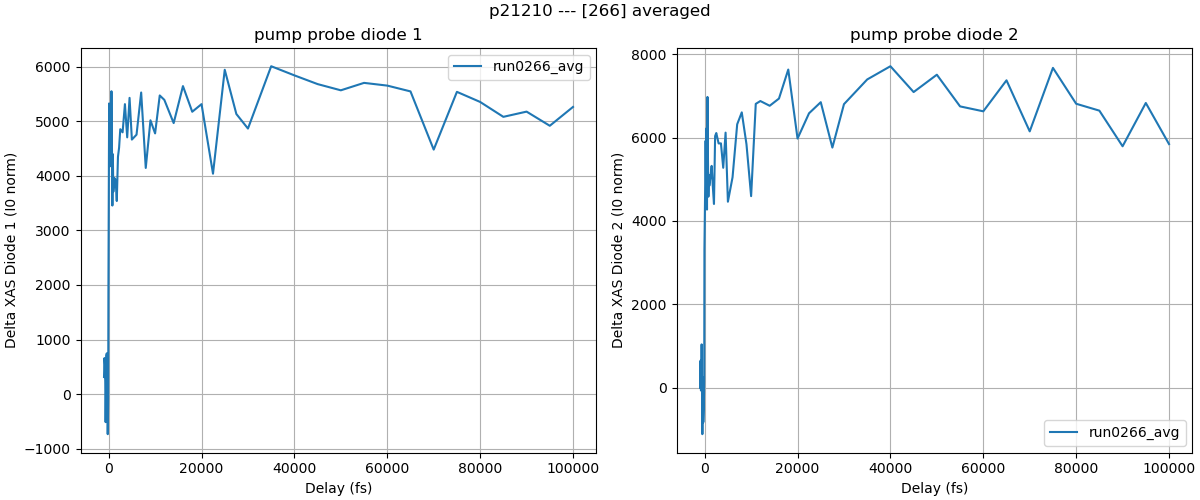

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack + ' averaged')

keys = []

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key, values in run_array.items():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        rbk = run_array[key]["readbacks"]
        t0mm = run_array[key]["timezero_mm"]
        params = run_array[key]["scan_params"]
        Delay_mm, Delay_fs = adjust_delayaxis(params, rbk, t0mm)
        
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
                        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.plot(Delay_fs, XAS1_pump_probe[:,0], label=runnumber)
        #ax1.plot(Delay_fs, (D1u[:,0] - np.mean(D1u[:5,0])) , label=runnumber)
        #ax2.plot(Delay_fs, (D1u[:,0] - np.mean(D1u[:5,0]))/np.max(D1u[:,0]) , label=runnumber)
        #ax1.plot(Delay_fs, D1p[:,0])
        #ax1.axes.errorbar(Delay_fs, D1u[:,0], err1_low_unpump, err1_high_unpump, label=runnumber)
        #ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
        D2p = run_array[key]["DataDiode2_pump"]
        D2u = run_array[key]["DataDiode2_unpump"]
        gs2 = run_array[key]["goodshots2"]

        err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
        err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
        err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
        err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)

        err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
        err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

        ax2.plot(Delay_fs, XAS2_pump_probe[:,0], label=runnumber)
        #ax2.axes.errorbar(Delay_fs, D2u[:,0], err2_low_unpump, err2_high_unpump, label=runnumber)
        
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 1')
ax2.set_title('pump probe diode 2')

plt.show()

<a id='average_2diodes'></a>
## Average the 2 diodes

Scan is done with the stage in fs


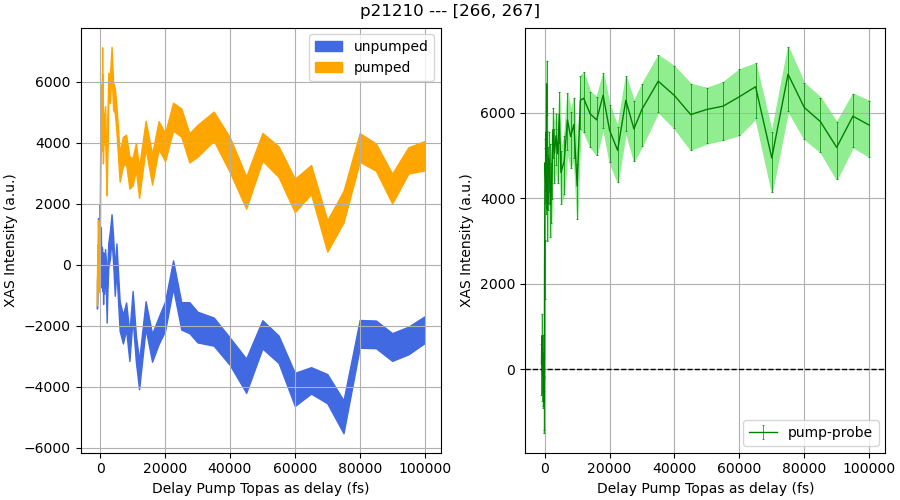

In [6]:
Delay_fs, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring_stack, scan, data, nscans=2, timescan=True)
#Delay_fs, ave_pp1 = Plot_2diodes_Averaged_1fig(titlestring_stack, scan, data, nscans=2, timescan=True)